In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
import talib as ta
from finta import TA

import warnings
warnings.filterwarnings('ignore')

In [2]:
# the pandas webreader provides remote data access to apis
import pandas_datareader as webreader

date_today = "2020-01-01"
date_start = "2010-01-01"

# set the symbol to bitcoin-usd quotes
# for more symbols check yahoo.finance.com
symbol = "BTC-USD"

In [3]:
# now we will send the request to the yahoo finance api endpoint
df = webreader.DataReader(symbol, start=date_start, end=date_today, data_source="yahoo")
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,21056800,457.334015
2014-09-18,456.859985,413.104004,456.859985,424.440002,34483200,424.440002
2014-09-19,427.834991,384.532013,424.102997,394.795990,37919700,394.795990
2014-09-20,423.295990,389.882996,394.673004,408.903992,36863600,408.903992
2014-09-21,412.425995,393.181000,408.084991,398.821014,26580100,398.821014


In [4]:
df['50 SMA'] = ta.SMA(df['Close'], timeperiod=50)
df

,High,Low,Open,Close,Volume,Adj Close,50 SMA
Date,,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,21056800,457.334015,NaN
2014-09-18,456.859985,413.104004,456.859985,424.440002,34483200,424.440002,NaN
2014-09-19,427.834991,384.532013,424.102997,394.795990,37919700,394.795990,NaN
2014-09-20,423.295990,389.882996,394.673004,408.903992,36863600,408.903992,NaN
2014-09-21,412.425995,393.181000,408.084991,398.821014,26580100,398.821014,NaN
...,...,...,...,...,...,...,...
2019-12-29,7513.948242,7279.865234,7317.647461,7422.652832,22445257702,7422.652832,7594.035234
2019-12-30,7454.824219,7276.308105,7420.272949,7292.995117,22874131672,7292.995117,7558.784609
2019-12-31,7335.290039,7169.777832,7294.438965,7193.599121,21167946112,7193.599121,7527.500830


In [5]:
df.to_csv('Df-50day')

In [6]:
 # Get standard deviation
period = 20
Symbol=df
Symbol['std'] = df['Close'].rolling(period).std()

  # Calculate Upper Bollinger band
Symbol['upper'] = df['50 SMA']  + (2 * Symbol['std'])
    # Calculate Lower Bollinger band
Symbol['lower'] = df['50 SMA']  - (2 * Symbol['std'])

In [7]:
    # prepare buy and sell signals. The lists prepared are still panda data frames with float nos
    
    close_list = pd.to_numeric(df['Close'], downcast='float')
    upper_list = pd.to_numeric(Symbol['upper'], downcast='float')
    lower_list = pd.to_numeric(Symbol['lower'], downcast='float')
    df['buy'] = np.where(close_list < lower_list,   df['Close'], np.NaN )
    df['sell'] = np.where(close_list > upper_list,   df['Close'], np.NaN )

In [8]:
 # To print in human-readable date and time (from timestamp)
  
 
with open('BollingerBands.txt', 'w') as f:
        f.write(Symbol.to_string())

In [9]:
training_set = df.iloc[:,2:3].values

print(training_set)
print(training_set.shape)

[[ 465.86401367]
 [ 456.85998535]
 [ 424.10299683]
 ...
 [7294.43896484]
 [7194.89208984]
 [7202.55126953]]
(1934, 1)


In [10]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_training_set = scaler.fit_transform(training_set)
scaled_training_set

array([[0.01497323],
       [0.01450668],
       [0.01280933],
       ...,
       [0.36880551],
       [0.36364734],
       [0.36404421]])

In [11]:
X_train = []
y_train = []
for i in range (60,1258):
    X_train.append(scaled_training_set[i-60:i,0])
    y_train.append(scaled_training_set[i,0])
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(1198, 60)
(1198,)


In [12]:
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1],1))

X_train.shape

(1198, 60, 1)

In [13]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [14]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences= True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50,))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

In [21]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
38/38 [==============================] - 7s 43ms/step - loss: 8.6735e-04
Epoch 2/25
38/38 [==============================] - 2s 43ms/step - loss: 7.5614e-04
Epoch 3/25
38/38 [==============================] - 2s 42ms/step - loss: 8.1822e-04
Epoch 4/25
38/38 [==============================] - 2s 42ms/step - loss: 6.8319e-04
Epoch 5/25
38/38 [==============================] - 2s 43ms/step - loss: 7.3469e-04
Epoch 6/25
38/38 [==============================] - 2s 43ms/step - loss: 7.9366e-04
Epoch 7/25
38/38 [==============================] - 2s 43ms/step - loss: 5.7679e-04
Epoch 8/25
38/38 [==============================] - 2s 43ms/step - loss: 7.5771e-04
Epoch 9/25
38/38 [==============================] - 2s 43ms/step - loss: 7.1091e-04
Epoch 10/25
38/38 [==============================] - 2s 43ms/step - loss: 6.4824e-04
Epoch 11/25
38/38 [==============================] - 2s 43ms/step - loss: 8.3991e-04
Epoch 12/25
38/38 [==============================] - 2s 43ms/step - loss: 

In [22]:
dataset_test = pd.read_csv("Df-50day.csv")
actual_stock_price = df.iloc[:,2:3].values
actual_stock_price

array([[ 465.86401367],
       [ 456.85998535],
       [ 424.10299683],
       ...,
       [7294.43896484],
       [7194.89208984],
       [7202.55126953]])

In [23]:
dataset_total = pd.concat((df['Open'], dataset_test['Open']), axis=0)
inputs = dataset_total[len(dataset_total)-len(dataset_test)-60:].values

inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range (60,80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

In [24]:
predicted_crypto_price = regressor.predict(X_test)
predicted_crypto_price = scaler.inverse_transform(predicted_crypto_price)

1/1 [==============================] - 1s 1s/step


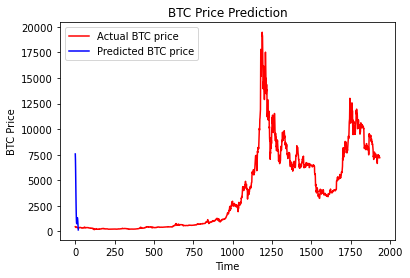

In [25]:
plt.plot(actual_stock_price, color= 'red', label = "Actual BTC price")
plt.plot(predicted_crypto_price, color = 'blue', label = "Predicted BTC price")
plt.title("BTC Price Prediction")
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()

In [27]:
df1 =df.sort_values('Date')
df1

,High,Low,Open,Close,Volume,Adj Close,50 SMA,std,upper,lower,buy,sell
Date,,,,,,,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,21056800,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,456.859985,413.104004,456.859985,424.440002,34483200,424.440002,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,427.834991,384.532013,424.102997,394.795990,37919700,394.795990,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-20,423.295990,389.882996,394.673004,408.903992,36863600,408.903992,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-21,412.425995,393.181000,408.084991,398.821014,26580100,398.821014,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29,7513.948242,7279.865234,7317.647461,7422.652832,22445257702,7422.652832,7594.035234,179.979293,7953.993820,7234.076648,NaN,NaN
2019-12-30,7454.824219,7276.308105,7420.272949,7292.995117,22874131672,7292.995117,7558.784609,180.244700,7919.274010,7198.295209,NaN,NaN
2019-12-31,7335.290039,7169.777832,7294.438965,7193.599121,21167946112,7193.599121,7527.500830,180.375203,7888.251236,7166.750424,NaN,NaN


In [28]:

scaler = MinMaxScaler()

close_price = df1.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [29]:

scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [30]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [47]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional
from keras.layers import Bidirectional, CuDNNLSTM
from keras.layers import Activation, Dense
DROPOUT = 0.2

WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=False)
))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [48]:

BATCH_SIZE = 64

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node sequential_5/bidirectional_6/forward_cu_dnnlstm_6/CudnnRNNV2}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", is_training=true, seed2=0]
Registered devices: [CPU]
Registered kernels:
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_DOUBLE]

	 [[sequential_5/bidirectional_6/forward_cu_dnnlstm_6/CudnnRNNV2]] [Op:__inference_train_function_64878]

ValueError: Found array with dim 3. LogisticRegression expected <= 2.